In [103]:
import pandas as pd
import numpy as np

lookup = pd.read_csv("/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Data_for_group_comparison/regions.csv")
df = pd.read_csv("/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Data_for_group_comparison/Three5xFAD_oligo_gene_MRI_merged_comparisonregions_updated_updated.csv")

# get allowed templateLabelABA values for cortex
cortex_labels = lookup.loc[
    lookup["region"] == "cc", "templateLabelABA"
].unique()
print(cortex_labels)

# filter main table
df_cortex = df[df["templateLabelABA"].isin(cortex_labels)]

# (optional) save
df_cortex.to_csv("/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Data_for_group_comparison/Three5xFAD_oligo_gene_MRI_merged_comparisonregions_cc.csv", index=False)


[ 569  946  954  961  976 1097 1281]


In [67]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

region = "ac"
df_5xfad = pd.read_csv("/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Data_for_group_comparison/Three5xFAD_gene_MRI_merged_comparisonregions_" + region + ".csv")
df_b6 = pd.read_csv("/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Data_for_group_comparison/ThreeB6_gene_MRI_merged_comparisonregions_" + region + ".csv")

gene_cols = df_5xfad.columns[26:]  # columns 27:end


In [68]:
results = []

for gene in gene_cols:
    x1 = df_5xfad[gene].dropna().values
    x0 = df_b6[gene].dropna().values
    # remove NaNs
    x1 = x1[~np.isnan(x1)]
    x0 = x0[~np.isnan(x0)]

    # skip genes with no data
    if len(x1) == 0 or len(x0) == 0:
        log2fc = nan
        p = nan
        continue

    # Welch t-test
    stat, p = ttest_ind(x1, x0, equal_var=False)
    

    # log2 fold change (add epsilon to avoid log(0))
    mean1 = np.mean(x1)
    mean0 = np.mean(x0)
    
    if mean1 <= 0.01:
        continue   # skip this gene

    log2fc = np.log2((mean1+0.01) / (mean0+0.01))

    results.append([gene, mean1, mean0, log2fc, p])

stats_df = pd.DataFrame(
    results,
    columns=["gene_id", "mean_5xFAD", "mean_B6", "log2FC", "pval"]
)
stats_df = stats_df.dropna()

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [64]:
pvals = stats_df["pval"]
valid = np.isfinite(pvals)

pvals_fdr = np.full_like(pvals, np.nan)

reject, pvals_fdr[valid], _, _ = multipletests(
    pvals[valid],
    alpha=0.05,
    method="fdr_bh"
)

stats_df["FDR"] = pvals_fdr[valid]


stats_df.to_csv("groupcomparison_all_genes_stats_" + region + ".csv", index=False)

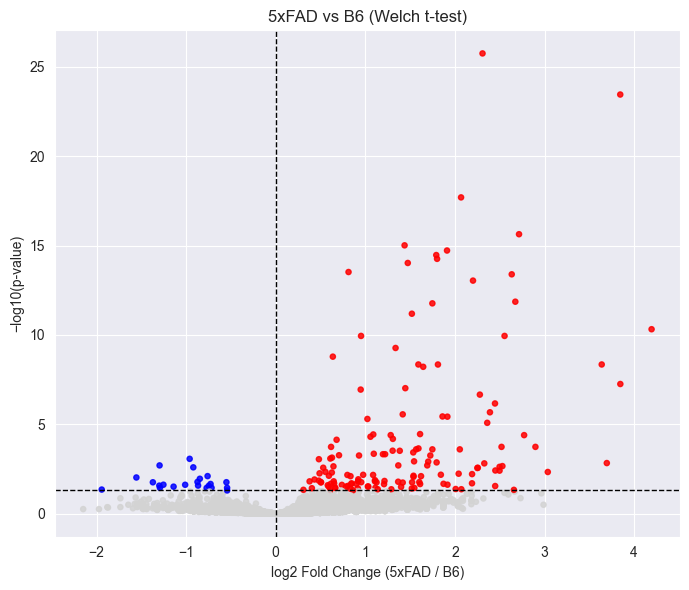

In [65]:
import matplotlib.pyplot as plt

stats_df["neglog10p"] = -np.log10(stats_df["FDR"].clip(1e-300))

stats_df["color"] = "lightgray"
stats_df.loc[(stats_df.FDR < 0.05) & (stats_df.log2FC > 0), "color"] = "red"
stats_df.loc[(stats_df.FDR < 0.05) & (stats_df.log2FC < 0), "color"] = "blue"

# cap fold-change for visualization only
stats_df["log2FC_plot"] = stats_df["log2FC"].clip(-5, 5)

plt.figure(figsize=(7, 6))

plt.scatter(
    stats_df["log2FC_plot"],
    stats_df["neglog10p"],
    c=stats_df["color"],
    s=14,
    alpha=0.85
)

plt.axhline(-np.log10(0.05), ls="--", lw=1, c="black")
plt.axvline(0, ls="--", lw=1, c="black")

plt.xlabel("log2 Fold Change (5xFAD / B6)")
plt.ylabel("−log10(p-value)")
plt.title("5xFAD vs B6 (Welch t-test)")

plt.tight_layout()
plt.savefig("volcano_5xFAD_vs_B6_welch_" + region + ".png", dpi=300)
plt.show()


In [66]:
top_up = stats_df[(stats_df.FDR < 0.05) & (stats_df.log2FC > 0)] \
    .sort_values("log2FC", ascending=False).head(10)

top_down = stats_df[(stats_df.FDR < 0.05) & (stats_df.log2FC < 0)] \
    .sort_values("log2FC").head(10)

top_up.to_csv("Top10_up_genes_" + region + ".csv", index=False)
top_down.to_csv("Top10_down_genes_" + region + ".csv", index=False)
sig_up = stats_df[(stats_df.FDR < 0.05) & (stats_df.log2FC > 0)] \
    .sort_values("pval")

sig_down = stats_df[(stats_df.FDR < 0.05) & (stats_df.log2FC < 0)] \
    .sort_values("pval")

sig_up.to_csv("Significant_up_genes_sortedbyp_" + region + ".csv", index=False)
sig_down.to_csv("Significant_down_genes_sortedbyp_" + region + ".csv", index=False)

In [104]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Step 1: Load significant MRI metrics
# -------------------------------
def load_significant_mri(delta_mri_csv, alpha=0.05):
    df = pd.read_csv(delta_mri_csv)
    sig = df[df['pval'] < alpha].copy()
    sig.set_index(['region', 'MRI_metric'], inplace=True)
    return sig[['delta_MRI']]

# -------------------------------
# Step 2: Load Δgenes from per-region, per-direction CSVs
# -------------------------------
def load_delta_genes_from_sig_files(
    sig_gene_dir,
    regions=('Cortex','HPF','OLF','CC'),
    directions=('up','down'),
    fad_col='mean_5xFAD',
    ctrl_col='mean_B6'
):
    sig_gene_dir = Path(sig_gene_dir)
    delta_gene_dict = {}

    for region in regions:
        delta_gene_dict[region] = {}
        for direction in directions:
            fname = f'Significant_{direction}_genes_sortedbyp_{region}.csv'
            fpath = sig_gene_dir / fname
            if not fpath.exists():
                raise FileNotFoundError(f'Missing file: {fpath}')

            df = pd.read_csv(fpath, index_col=0)
            if fad_col not in df.columns or ctrl_col not in df.columns:
                raise ValueError(f'{fpath} missing required columns')

            delta = df[fad_col] - df[ctrl_col]
            delta_gene_dict[region][direction] = delta.dropna()

    return delta_gene_dict

# -------------------------------
# Step 3: Within-region alignment analysis
# -------------------------------
def within_region_alignment_conditioned(
    sig_mri_df,
    delta_gene_dict,
    n_perm=10000,
    min_genes=5
):
    rows = []
    for (region, metric), row in sig_mri_df.iterrows():
        delta_mri = row['delta_MRI']
        if region not in delta_gene_dict:
            continue

        for direction in ['up','down']:
            gene_vals = delta_gene_dict[region][direction].values
            if len(gene_vals) < min_genes:
                continue

            obs = np.mean(np.sign(gene_vals) * np.sign(delta_mri))

            null = []
            for _ in range(n_perm):
                flipped = gene_vals * np.random.choice([-1,1], size=len(gene_vals))
                null.append(np.mean(np.sign(flipped) * np.sign(delta_mri)))
            null = np.asarray(null)
            p_perm = (np.sum(np.abs(null) >= abs(obs)) + 1) / (n_perm + 1)

            rows.append({
                'region': region,
                'MRI_metric': metric,
                'gene_direction': direction,
                'alignment_score': obs,
                'p_perm': p_perm,
                'n_genes': len(gene_vals)
            })

    return pd.DataFrame(rows)

# -------------------------------
# Step 4: Heatmap plotting function
# -------------------------------
def plot_alignment_heatmaps_sns(
    results_df,
    regions_order=None,
    metrics_order=None,
    vlim=1.0,
    alpha_sig=0.05,
    savepath=None
):
    """
    Side-by-side Up/Down heatmaps of MRI–gene alignment using sns.heatmap.
    """

    if regions_order is None:
        regions_order = results_df['region'].unique().tolist()
    if metrics_order is None:
        metrics_order = results_df['MRI_metric'].unique().tolist()

    fig, axes = plt.subplots(1, 2, figsize=(8, len(regions_order)*0.8), sharey=True)

    for ax, direction in zip(axes, ['up', 'down']):
        df = results_df[results_df['gene_direction'] == direction]

        # pivot to region x MRI_metric
        pivot = df.pivot(index='region', columns='MRI_metric', values='alignment_score')
        pivot = pivot.loc[regions_order, metrics_order]

        # pvals for significance annotation
        pvals = df.pivot(index='region', columns='MRI_metric', values='p_perm')
        pvals = pvals.loc[regions_order, metrics_order]

        sns.heatmap(
            pivot,
            ax=ax,
            cmap='coolwarm',
            center=0,
            vmin=-vlim,
            vmax=vlim,
            annot=False,
            cbar=(ax==axes[1]),  # only one colorbar on right
            linewidths=0,         # no white borders
            linecolor=None
        )

        # # significance stars
        # for i in range(pivot.shape[0]):
        #     for j in range(pivot.shape[1]):
        #         p = pvals.iloc[i, j]
        #         if pd.notna(p) and p < alpha_sig:
        #             ax.text(j + 0.5, i + 0.5, '*', ha='center', va='center', color='black', fontsize=12)

        ax.set_title(f'{direction.capitalize()} genes', fontsize=11)
        ax.set_xlabel('')
        if ax == axes[0]:
            ax.set_ylabel('Region', fontsize=10)
        else:
            ax.set_ylabel('')
        ax.set_yticks(np.arange(len(regions_order)) + 0.5)
        ax.set_yticklabels(regions_order, rotation=0)

    # plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches='tight')
        plt.close()
    else:
        plt.show()


In [105]:
# Paths
sig_gene_dir = '/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Data_for_group_comparison/results/Significant_gene_files'
delta_mri_csv = '/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Data_for_group_comparison/results/MRI_delta_pval.csv'

# Load data
sig_mri_df = load_significant_mri(delta_mri_csv, alpha=0.05)
delta_gene_dict = load_delta_genes_from_sig_files(sig_gene_dir)

# Run within-region alignment
results_df = within_region_alignment_conditioned(
    sig_mri_df=sig_mri_df,
    delta_gene_dict=delta_gene_dict,
    n_perm=10000,
    min_genes=5
)

# Optional: order of regions/metrics
regions_order = ['Cortex','HPF','OLF','CC']
metrics_order = sig_mri_df.reset_index()['MRI_metric'].unique().tolist()

# Plot heatmaps

plot_alignment_heatmaps_sns(
    results_df=results_df,
    regions_order=regions_order,
    metrics_order=metrics_order,
    savepath='Fig_alignment_heatmaps_sns_nostars.png'
)


In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_alignment_heatmaps_values_fixed(
    results_df,
    regions_order=None,
    metrics_order=None,
    alpha_sig=0.05,
    savepath=None
):
    """
    Side-by-side Up/Down heatmaps of continuous MRI–gene correlation,
    showing correlation values and significance stars.
    Handles single-row or NaN cases robustly.
    """

    if regions_order is None:
        regions_order = results_df['region'].unique().tolist()
    if metrics_order is None:
        metrics_order = results_df['MRI_metric'].unique().tolist()

    # Determine symmetric vmin/vmax across all correlations
    max_abs_corr = results_df['alignment_score'].abs().max()
    vlim = max_abs_corr if max_abs_corr > 0 else 1.0

    fig, axes = plt.subplots(1, 2, figsize=(8, len(regions_order)*0.8), sharey=True)

    for ax, direction in zip(axes, ['up', 'down']):
        df_dir = results_df[results_df['gene_direction'] == direction]

        # pivot table: region x MRI_metric
        pivot = df_dir.pivot(index='region', columns='MRI_metric', values='alignment_score')
        pivot = pivot.reindex(index=regions_order, columns=metrics_order)

        # p-values
        pvals = df_dir.pivot(index='region', columns='MRI_metric', values='p_perm')
        pvals = pvals.reindex(index=regions_order, columns=metrics_order)

        # create annotation strings
        annot_matrix = np.empty(pivot.shape, dtype=object)
        for i in range(pivot.shape[0]):
            for j in range(pivot.shape[1]):
                val = pivot.iloc[i, j]
                if pd.isna(val):
                    annot_matrix[i,j] = ""
                else:
                    val_str = f"{val:.2f}"
                    if pd.notna(pvals.iloc[i,j]) and pvals.iloc[i,j] < alpha_sig:
                        val_str += "*"
                    annot_matrix[i,j] = val_str

        # plot heatmap
        sns.heatmap(
            pivot.values,
            ax=ax,
            cmap='coolwarm',
            center=0,
            vmin=-vlim,
            vmax=vlim,
            annot=annot_matrix,
            fmt='',
            cbar=(ax==axes[1]),
            linewidths=0,
            linecolor=None,
            square=True
        )

        ax.set_title(f'{direction.capitalize()} genes', fontsize=11)
        ax.set_xlabel('')
        if ax == axes[0]:
            ax.set_ylabel('Region', fontsize=10)
        else:
            ax.set_ylabel('')
        ax.set_yticks(np.arange(len(regions_order)) + 0.5)
        ax.set_yticklabels(regions_order, rotation=0)

        # set x-tick labels
        ax.set_xticks(np.arange(len(metrics_order)) + 0.5)
        ax.set_xticklabels(metrics_order, rotation=45, ha='right', fontsize=8)

    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches='tight')
        plt.close()
    else:
        plt.show()


In [94]:
# Load significant MRI and Δgenes as before
sig_mri_df = load_significant_mri('/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Data_for_group_comparison/results/MRI_delta_pval.csv', alpha=0.05)
delta_gene_dict = load_delta_genes_from_sig_files('/Volumes/Wanglab_HDD1/UTSW/Xinyue/AD_Cell_Type/Data_for_group_comparison/results/Significant_gene_files')

# Optional: order of regions/metrics
regions_order = ['Cortex','HPF','OLF','CC']
metrics_order = sig_mri_df.reset_index()['MRI_metric'].unique().tolist()

plot_alignment_heatmaps_values_fixed(
    results_df=results_df,
    regions_order=regions_order,
    metrics_order=metrics_order,
    savepath='Fig_alignment_final.png'
)




